<a href="https://colab.research.google.com/github/ras1364/Fake-Review-Using-BERT/blob/main/FakeReviewDetectionUsingBertVer3_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this code, comments are sent to the BERT encoder regardless of the number of sentences, and its output is sent to the SVM classifier.**

In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import files
uploaded = files.upload()

Saving X_test.csv to X_test.csv
Saving X_train.csv to X_train.csv
Saving y_test.csv to y_test.csv
Saving y_train.csv to y_train.csv


In [3]:
X_test = pd.read_csv("/content/X_test.csv")
X_train = pd.read_csv("/content/X_train.csv")
y_test = pd.read_csv("/content/y_test.csv")
y_train = pd.read_csv("/content/y_train.csv")

In [4]:
max_length = 100
# for x in range(0,len(X_train)):
#   line = X_train.loc[x].at["text"]
#   if max_length < len(line.split()) :
#     max_length = len(line.split())

print(max_length)


100


In [5]:
from gensim.parsing.preprocessing import remove_stopwords

def preprocess(text):
  return remove_stopwords(text)

X_train["stemmed_text_data"] = X_train["text"].map(preprocess)
X_test["stemmed_text_data"] = X_test["text"].map(preprocess)

In [6]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 17.4 MB/s eta 0:00:00


In [7]:
from transformers import AutoTokenizer, TFBertModel 
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# For Test
# encoded = tokenizer.encode_plus("Hello beautifull human, i'm Reza", return_tensors="tf")
# embedding = bert_model(encoded['input_ids'],encoded['attention_mask'])

In [8]:
def percent_complete(step, total_steps, bar_width=60, title="", print_perc=True):
    import sys

    # UTF-8 left blocks: 1, 1/8, 1/4, 3/8, 1/2, 5/8, 3/4, 7/8
    utf_8s = ["█", "▏", "▎", "▍", "▌", "▋", "▊", "█"]
    perc = 100 * float(step) / float(total_steps)
    max_ticks = bar_width * 8
    num_ticks = int(round(perc / 100 * max_ticks))
    full_ticks = num_ticks / 8      # Number of full blocks
    part_ticks = num_ticks % 8      # Size of partial block (array index)
    
    disp = bar = ""                 # Blank out variables
    bar += utf_8s[0] * int(full_ticks)  # Add full blocks into Progress Bar
    
    # If part_ticks is zero, then no partial block, else append part char
    if part_ticks > 0:
        bar += utf_8s[part_ticks]
    
    # Pad Progress Bar with fill character
    bar += "▒" * int((max_ticks/8 - float(num_ticks)/8.0))
    
    if len(title) > 0:
        disp = title + ": "         # Optional title to progress display
    
    # Print progress bar in green: https://stackoverflow.com/a/21786287/6929343
    disp += "\x1b[0;32m"            # Color Green
    disp += bar                     # Progress bar to progress display
    disp += "\x1b[0m"               # Color Reset
    if print_perc:
        # If requested, append percentage complete to progress display
        if perc > 100.0:
            perc = 100.0            # Fix "100.04 %" rounding error
        disp += " {:6.2f}".format(perc) + " %"
    
    # Output to terminal repetitively over the same line using '\r'.
    sys.stdout.write("\r" + disp)
    sys.stdout.flush()

In [9]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
import tensorflow as tf

def encode(text, maxlen,mtitle):
  embeddings=[]
  counter = 1
  for row in text:
    embedding =[]
    counter+=1
    percent_complete(counter, len(text), title=mtitle)
    for sent in sent_tokenize(row):
      encoded = tokenizer.encode_plus(
          sent,
          add_special_tokens=True,
          max_length=maxlen,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors="tf"
      )
      embedding.append(bert_model(encoded['input_ids'],encoded['attention_mask'])[1])
    loop = 50 - len(embedding)
    for x in range(loop):
      embedding.append(tf.zeros([1,768],tf.int32))
    embeddings.append(embedding)

  return embeddings

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# for test
my_test= {"I love my little son. He is very qiute.","He is hamed and he was sick. he is best football player.","I love my little son. He is very qiute.","He is hamed and he was sick. he is best football player."}
my_test_encoded = encode(my_test,5)

Convert Markdown: ██████████████████████████████████████████████████████████████████████████████████████████ 100.00 %

In [10]:
X_train_embedding = encode(X_train.stemmed_text_data,max_length,"X_train_embedding")
X_test_embedding  = encode(X_test.stemmed_text_data,max_length,"X_test_embedding")

X_train_embedding: ▏▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒   0.17 %

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


X_test_embedding: ████████████████████████████████████████████████████████████▏ 100.00 %

In [11]:
np.shape(X_train_embedding)

(1200, 50, 1, 768)

In [14]:
X_train_embedding_squeezed = np.squeeze(X_train_embedding)
X_test_embedding_squeezed = np.squeeze(X_test_embedding)
print(np.shape(X_train_embedding_squeezed))
print(np.shape(X_test_embedding_squeezed))

(1200, 50, 768)
(400, 50, 768)


In [17]:
from tempfile import TemporaryFile
X_train_embedded_file = TemporaryFile()
X_test_embedded_file = TemporaryFile()
np.save(X_train_embedded_file,X_train_embedding_squeezed)
np.save(X_test_embedded_file,X_test_embedding_squeezed)


In [19]:
np.save("X_train_embedded_file.npy",X_train_embedding_squeezed)
np.save("X_test_embedded_file.npy",X_test_embedding_squeezed)


In [45]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def build_model():
   input = tf.keras.Input(shape=(50,768,),dtype='int32')
   pooler = tf.keras.layers.MaxPooling1D(pool_size=(50))(input)

   output = tf.keras.layers.Dense(32,activation='relu')(pooler)
   output = tf.keras.layers.Dropout(0.2)(output)
   output = tf.keras.layers.Dense(1,activation='sigmoid')(output)

   model = tf.keras.models.Model(inputs = input , outputs = output)
   model.compile(Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

   return model


In [46]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 50, 768)]         0         
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1, 768)           0         
 1D)                                                             
                                                                 
 dense (Dense)               (None, 1, 32)             24608     
                                                                 
 dropout_37 (Dropout)        (None, 1, 32)             0         
                                                                 
 dense_1 (Dense)             (None, 1, 1)              33        
                                                                 
Total params: 24,641
Trainable params: 24,641
Non-trainable params: 0
_________________________________________________________

In [56]:
history = model.fit(
    X_train_embedding_squeezed,
    y_train.deceptive,
    batch_size=32,
    epochs=5,
    validation_data=(X_test_embedding_squeezed, y_test.deceptive))

Epoch 1/5
38/38 [==============================] - 1s 23ms/step - loss: 0.6904 - accuracy: 0.5383 - val_loss: 0.6882 - val_accuracy: 0.5500
Epoch 2/5
38/38 [==============================] - 1s 15ms/step - loss: 0.6882 - accuracy: 0.5608 - val_loss: 0.6882 - val_accuracy: 0.5500
Epoch 3/5
38/38 [==============================] - 1s 16ms/step - loss: 0.6860 - accuracy: 0.5367 - val_loss: 0.6882 - val_accuracy: 0.5500
Epoch 4/5
38/38 [==============================] - 1s 17ms/step - loss: 0.6897 - accuracy: 0.5225 - val_loss: 0.6881 - val_accuracy: 0.5500
Epoch 5/5
38/38 [==============================] - 1s 18ms/step - loss: 0.6865 - accuracy: 0.5392 - val_loss: 0.6881 - val_accuracy: 0.5500


In [57]:
loss, accuracy = model.evaluate(X_test_embedding_squeezed, y_test.deceptive)
print('Test accuracy :', accuracy ,' and loss = ', loss)

13/13 [==============================] - 0s 11ms/step - loss: 0.6881 - accuracy: 0.5500
Test accuracy : 0.550000011920929  and loss =  0.6880924105644226


In [58]:
y_predicted = model.predict(X_test_embedding_squeezed)
y_predicted = y_predicted.flatten()

13/13 [==============================] - 1s 10ms/step


In [59]:
import numpy as np
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,

In [60]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test.deceptive, y_predicted)
cm 

array([[134,  66],
       [114,  86]])

Text(33.0, 0.5, 'Truth')

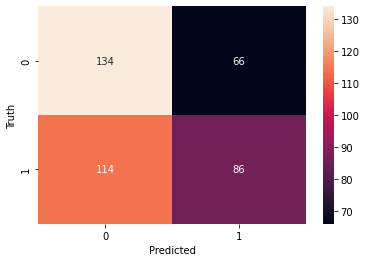

In [61]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [62]:
print(classification_report(y_test.deceptive, y_predicted))

              precision    recall  f1-score   support

           0       0.54      0.67      0.60       200
           1       0.57      0.43      0.49       200

    accuracy                           0.55       400
   macro avg       0.55      0.55      0.54       400
weighted avg       0.55      0.55      0.54       400

